# Question 1 — Step 1: Create a W×W image with a white line y = x

**Goal:**  
- Create a square image of size W×W with a black background and a white line at y = x.
- Display the image to verify correct rendering.

**Notes:**  
- Use NumPy to build the image matrix and matplotlib for display.
- Pixel convention: 0 = black, 255 = white.
- Indexing: img[row, col] = img[y, x].


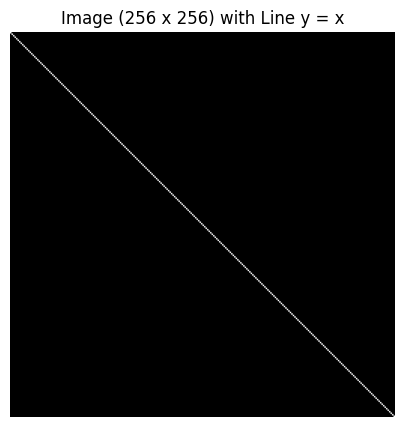

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Create a W x W image (black background)
W = 256
img = np.zeros((W, W), dtype=np.uint8)

# Draw the white line y = x
for x in range(W):
    y = x
    img[y, x] = 255

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Image (256 x 256) with Line y = x')
plt.axis('off')
plt.show()


# Step 2A — Manual 2D DFT (Brute-Force, Slow Version)

**Goal:**  
Compute the 2D DFT of the image using the direct mathematical definition:
4 nested loops over (u, v, x, y).

**Why 64×64?**  
This brute-force implementation is O(W⁴), which becomes extremely slow for 256×256.  
So we downsample the original image to 64×64 for this version.

**Outputs:**  
- Real part of DFT
- Imaginary part of DFT
- Magnitude spectrum
- Phase spectrum


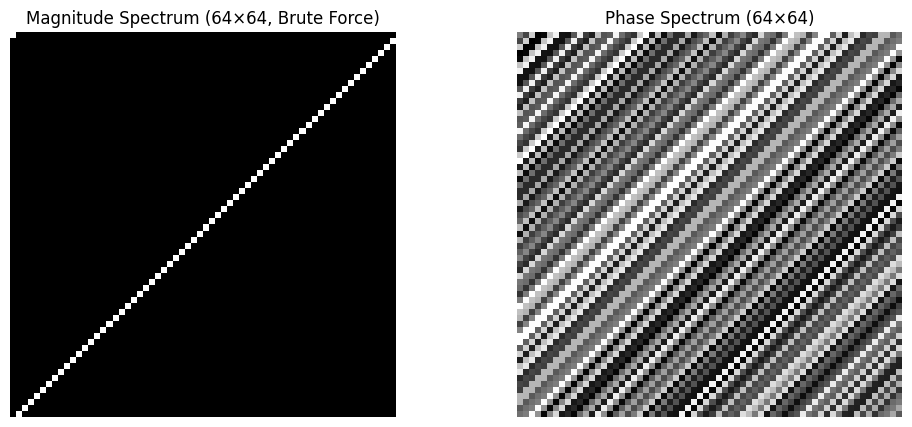

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Downsample for brute-force DFT
img_64 = img[::4, ::4]   # from 256→64

W = img_64.shape[0]

def dft_bruteforce(image):
    W = image.shape[0]

    F_real = np.zeros((W, W))
    F_imag = np.zeros((W, W))

    # ---- 4 nested loops ----
    for u in range(W):
        for v in range(W):

            real_sum = 0.0
            imag_sum = 0.0

            for x in range(W):
                for y in range(W):
                    angle = -2 * np.pi * ((u * x) / W + (v * y) / W)
                    value = image[y, x]

                    # TODO: complete these three lines:
                    angle = -2 * np.pi * ((u * x) / W + (v * y) / W)
                    real_sum += value * np.cos(angle)
                    imag_sum += value * np.sin(angle)


            F_real[u, v] = real_sum
            F_imag[u, v] = imag_sum

    return F_real, F_imag

# Compute DFT
F_real_64, F_imag_64 = dft_bruteforce(img_64)

# Magnitude and phase
magnitude_64 = np.sqrt(F_real_64**2 + F_imag_64**2)
phase_64 = np.arctan2(F_imag_64, F_real_64)

# Display
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(np.log1p(magnitude_64), cmap='gray')
plt.title("Magnitude Spectrum (64×64, Brute Force)")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(phase_64, cmap='gray')
plt.title("Phase Spectrum (64×64)")
plt.axis('off')

plt.show()


# Step 2B — Optimized Manual 2D DFT (Vectorized)

**Idea:**
Instead of computing cos/sin inside four nested loops, we precompute:

- A matrix Ex where Ex[u, x] = exp(-j 2π u x / W)
- A matrix Ey where Ey[v, y] = exp(-j 2π v y / W)

Then the 2D DFT becomes:

    F = Ex  ·  image  ·  Eyᵀ

This is still a manual DFT (not using np.fft),  
but it is much faster and allows running on 256×256 images.


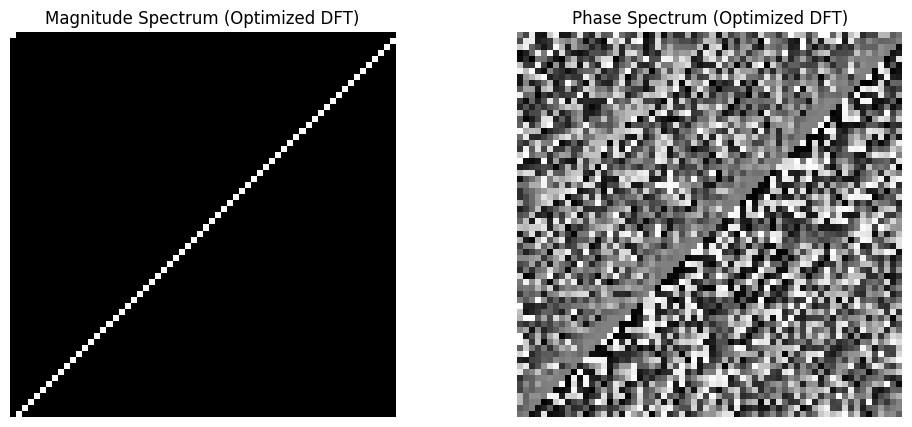

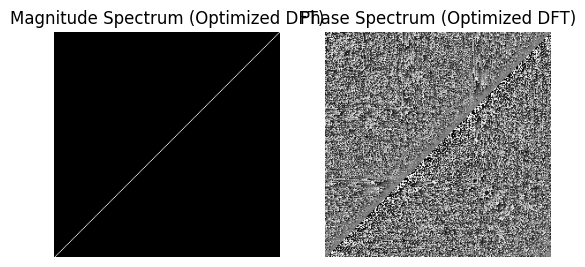

In [4]:
import numpy as np

def dft_optimized(image):
    W = image.shape[0]

    # Step 1 — create indices
    x = np.arange(W)
    y = np.arange(W)
    u = np.arange(W)
    v = np.arange(W)

    # --------------------------------------------------
    # Step 2 — Compute the Ex and Ey exponential matrices
    # Ex[u, x] = exp(-j * 2π * (u*x)/W)
    # Ey[v, y] = exp(-j * 2π * (v*y)/W)
    # TODO: Use np.outer + np.exp
    # --------------------------------------------------
    UX = np.outer(u, x)
    Ex = np.exp(-2j * np.pi * UX / W)
    VY = np.outer(v, y)
    Ey = np.exp(-2j * np.pi * VY / W)
    # --------------------------------------------------

    # --------------------------------------------------
    # Step 3 — Apply DFT using matrix multiplication
    # F = Ex @ image @ Ey.T
    # --------------------------------------------------
    F = Ex @ image @ Ey.T
    # --------------------------------------------------

    # --------------------------------------------------
    # Step 4 — separate real and imaginary parts
    # --------------------------------------------------
    F_real = np.real(F)
    F_imag = np.imag(F)

    return F_real, F_imag

# Compute DFT
F_real_64, F_imag_64 = dft_optimized(img_64)
magnitude_64 = np.sqrt(F_real_64**2 + F_imag_64**2)
phase_64 = np.arctan2(F_imag_64, F_real_64)

F_real_256, F_imag_256 = dft_optimized(img)
magnitude_256 = np.sqrt(F_real_256**2 + F_imag_256**2)
phase_256 = np.arctan2(F_imag_256, F_real_256)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Magnitude Spectrum (64×64, Optimized)
plt.subplot(1, 2, 1)
plt.imshow(np.log1p(magnitude_64), cmap='gray')
plt.title("Magnitude Spectrum (Optimized DFT)")
plt.axis('off')

# Phase Spectrum (64×64, Optimized)
plt.subplot(1, 2, 2)
plt.imshow(phase_64, cmap='gray')
plt.title("Phase Spectrum (Optimized DFT)")
plt.axis('off')

plt.show()

# Magnitude Spectrum (256×256, Optimized)
plt.subplot(1, 2, 1)
plt.imshow(np.log1p(magnitude_256), cmap='gray')
plt.title("Magnitude Spectrum (Optimized DFT)")
plt.axis('off')

# Phase Spectrum (256×256, Optimized)
plt.subplot(1, 2, 2)
plt.imshow(phase_256, cmap='gray')
plt.title("Phase Spectrum (Optimized DFT)")
plt.axis('off')

plt.show()




# Step 4 — Manual Frequency Shifting (fftshift-like)

To visualize the DFT more clearly, we move the low-frequency components
from the corners of the spectrum to the center. Since np.fft.fftshift()
is not allowed, we manually swap the four quadrants of the magnitude
spectrum.

Quadrant mapping:
    Q1 ↔ Q4
    Q2 ↔ Q3

This produces a centered magnitude spectrum similar to standard FFT
visualizations.


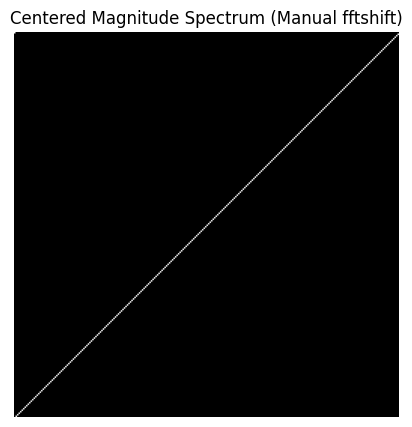

In [5]:
def manual_fftshift(mag):
    W = mag.shape[0]
    half = W // 2

    shifted = np.zeros_like(mag)

    # Quadrants:
    # Q1: [0:half,     0:half]
    # Q2: [0:half,     half:W]
    # Q3: [half:W,     0:half]
    # Q4: [half:W,     half:W]

    # TODO: fill these four assignments:

    shifted[half:W, half:W] = mag[0:half, 0:half]     # Q1 → Q4
    shifted[half:W, 0:half] = mag[0:half, half:W]     # Q2 → Q3
    shifted[0:half,  half:W] = mag[half:W, 0:half]    # Q3 → Q2
    shifted[0:half,  0:half] = mag[half:W, half:W]    # Q4 → Q1

    return shifted

mag_shifted = manual_fftshift(np.log1p(magnitude_256))

plt.figure(figsize=(5,5))
plt.imshow(mag_shifted, cmap='gray')
plt.title("Centered Magnitude Spectrum (Manual fftshift)")
plt.axis('off')
plt.show()
